In [2]:
import pandas as pd
ndf = pd.read_pickle('../IR/graph_IR.pickle')
import warnings
# Ignore DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
ndf.head()

,path,inter
0,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1644 [label=""category_nam..."
1,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1647 [label=""var: db.secr..."
2,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1651 [label=""enabled: Tru..."
3,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1654 [label=""msg: This is..."
4,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1660 [label=""repo: deb ht..."


In [4]:
import networkx as nx
import pydot
dists = []
for i in range(len(ndf)):
    gi = nx.nx_pydot.from_pydot(pydot.graph_from_dot_data(ndf.loc[i, 'inter'])[0])
    for j in range(i+1, len(ndf)):
        gj = nx.nx_pydot.from_pydot(pydot.graph_from_dot_data(ndf.loc[j, 'inter'])[0])
        dists.append([v for v in nx.optimize_graph_edit_distance(gi, gj)][-1])

In [5]:
from scipy.spatial.distance import squareform
# Create distance matrix
dist_matrix = squareform(dists)

In [6]:
dist_matrix

array([[0., 4., 2., ..., 0., 2., 0.],
       [4., 0., 6., ..., 4., 6., 4.],
       [2., 6., 0., ..., 2., 0., 2.],
       ...,
       [0., 4., 2., ..., 0., 2., 0.],
       [2., 6., 0., ..., 2., 0., 2.],
       [0., 4., 2., ..., 0., 2., 0.]])

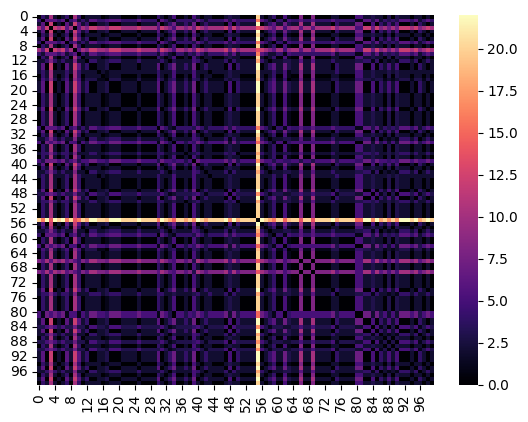

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap from dist_matrix
sns.heatmap(dist_matrix, cmap='magma')
plt.show()

In [8]:
import numpy as np

# Set the diagonal elements to infinity so they won't be considered as the minimum value
np.fill_diagonal(dist_matrix, 0)

# Get the row and column indices of the maximum value
row_idx, col_idx = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)

# Print the indices and the maximum value
print(f"The maximum value is at row {row_idx} and column {col_idx}, with a value of {dist_matrix[row_idx, col_idx]}")

The maximum value is at row 2 and column 55, with a value of 22.0


In [69]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Use the optimal number of clusters to perform K-means clustering
n_clusters = 100 # Example of using 3 clusters
scaler = StandardScaler()
dist_matrix_scaled = scaler.fit_transform(dist_matrix)
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0, n_init=10)
labels = kmeans.fit_predict(dist_matrix_scaled)

# Print the labels assigned to each data point
print(labels)

[ 0 12  2  3  2  0  2 12  0  3 16  0 19  2  2 23  0 10  2  2  2  0  0  0
  0  2  0  0  0  0 12  2  0 19 43  0  0 47  0 50  2  0 19 23  0  0  0  2
 60  2 47  0  0  0  0 96  2  0 19 12  0  0 43 10  0  0  1  0  0  1  0  0
  0  0  2  7  0  0  0  0 43 43  2  2 60  2 19  0 60  0 60  2  2  2  0  2
 19  0  2  0]


/data/minh/anaconda3/envs/fuzz/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [75]:
# Get unique values and count them
unique_values = set(labels)
len(unique_values)

15

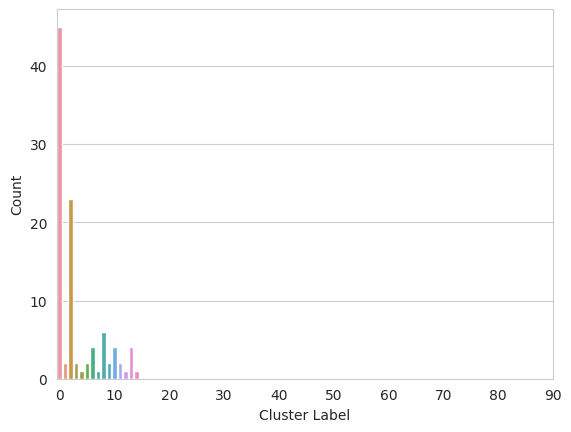

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
ax = sns.countplot(x=labels)
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Count')
ax.set_xticks(range(0, n_clusters, 10))
ax.set_xticklabels(range(0, n_clusters, 10))

plt.show()

In [72]:
ndf['over'] = labels

In [73]:
# Get the count of each label
label_counts = ndf['over'].value_counts()

# Print the label counts
print(label_counts)

0     45
2     23
19     6
12     4
43     4
60     4
3      2
23     2
10     2
47     2
1      2
16     1
50     1
96     1
7      1
Name: over, dtype: int64


In [74]:
ndf[ndf['over'] == 0].index

Int64Index([ 0,  5,  8, 11, 16, 21, 22, 23, 24, 26, 27, 28, 29, 32, 35, 36, 38,
            41, 44, 45, 46, 51, 52, 53, 54, 57, 60, 61, 64, 65, 67, 68, 70, 71,
            72, 73, 76, 77, 78, 79, 87, 89, 94, 97, 99],
           dtype='int64')

In [9]:
from sklearn.cluster import KMeans
# Determine the optimal number of clusters
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(dist_matrix)
    distortions.append(kmeanModel.inertia_)

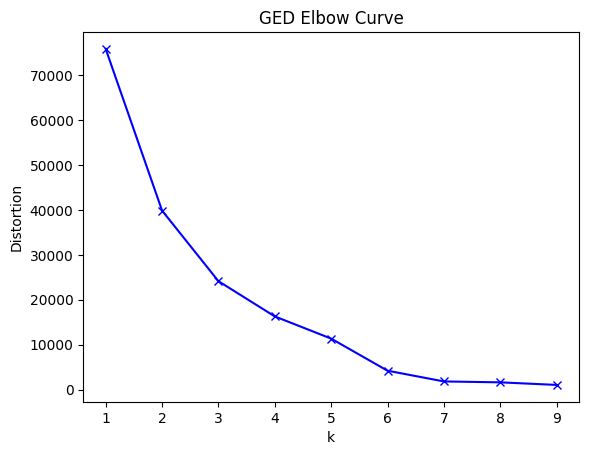

In [78]:
import matplotlib.pyplot as plt
# Plot the elbow curve to determine the optimal number of clusters
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('GED Elbow Curve')
plt.show()

In [76]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Use the optimal number of clusters to perform K-means clustering
n_clusters = 9 # Example of using 3 clusters
scaler = StandardScaler()
dist_matrix_scaled = scaler.fit_transform(dist_matrix)
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0, n_init=10)
labels = kmeans.fit_predict(dist_matrix_scaled)

# Print the labels assigned to each data point
print(labels)

[0 2 3 4 3 0 3 2 0 4 2 0 5 3 3 8 0 8 3 3 3 0 0 0 0 3 0 0 0 0 2 3 0 5 2 0 0
 5 0 2 3 0 5 8 0 0 0 3 7 3 5 0 0 0 0 1 3 0 5 2 0 0 2 8 0 0 6 0 0 6 0 0 0 0
 3 5 0 0 0 0 2 2 3 3 7 3 5 0 7 0 7 3 3 3 0 3 5 0 3 0]


In [77]:
# Get unique values and count them
unique_values = set(labels)
len(unique_values)

9

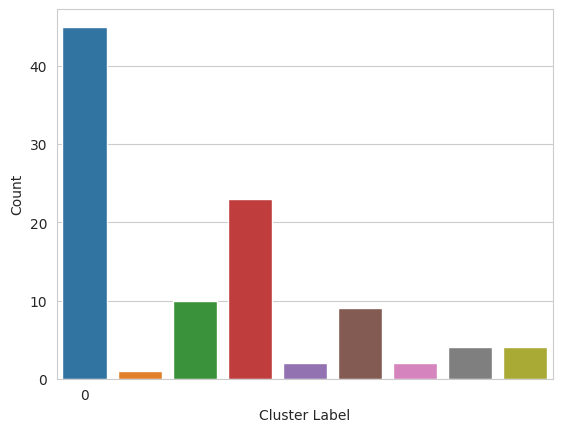

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
ax = sns.countplot(x=labels)
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Count')
ax.set_xticks(range(0, n_clusters, 10))
ax.set_xticklabels(range(0, n_clusters, 10))

plt.show()

In [79]:
ndf['elbow'] = labels

In [80]:
# Get the count of each label
label_counts = ndf['elbow'].value_counts()

# Print the label counts
print(label_counts)

0    45
3    23
2    10
5     9
8     4
7     4
4     2
6     2
1     1
Name: elbow, dtype: int64


In [81]:
ndf[ndf['elbow'] == 0].index

Int64Index([ 0,  5,  8, 11, 16, 21, 22, 23, 24, 26, 27, 28, 29, 32, 35, 36, 38,
            41, 44, 45, 46, 51, 52, 53, 54, 57, 60, 61, 64, 65, 67, 68, 70, 71,
            72, 73, 76, 77, 78, 79, 87, 89, 94, 97, 99],
           dtype='int64')

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Scale the data
scaler = StandardScaler()
dist_matrix_scaled = scaler.fit_transform(dist_matrix)

# Determine the optimal number of clusters using silhouette analysis
best_n_clusters = 2
best_silhouette_score = -1

for n_clusters in range(2, 20):  # Assuming you want to test from 2 to 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0, n_init=10)
    labels = kmeans.fit_predict(dist_matrix_scaled)
    silhouette_avg = silhouette_score(dist_matrix_scaled, labels)
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters
        print(silhouette_avg)

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, init='k-means++', random_state=0, n_init=10)
labels = kmeans.fit_predict(dist_matrix_scaled)

0.7660572833037562
0.7948315325027633
0.8307547691305288
0.8454424224542707
0.8539504906260162
0.8722962403865108
0.881510189288929
0.8944195774204414
0.9249015147435514
0.9485634921359163
0.9548495134798665
0.9599999710045114


/data/minh/anaconda3/envs/fuzz/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/data/minh/anaconda3/envs/fuzz/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/data/minh/anaconda3/envs/fuzz/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/data/minh/anaconda3/envs/fuzz/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (15) found smaller tha

In [37]:
labels

array([ 0,  4,  3,  8,  3,  0,  3,  4,  0,  8, 13,  0,  5,  3,  3,  9,  0,
       12,  3,  3,  3,  0,  0,  0,  0,  3,  0,  0,  0,  0,  4,  3,  0,  5,
        6,  0,  0, 10,  0, 11,  3,  0,  5,  9,  0,  0,  0,  3,  7,  3, 10,
        0,  0,  0,  0,  2,  3,  0,  5,  4,  0,  0,  6, 12,  0,  0,  1,  0,
        0,  1,  0,  0,  0,  0,  3, 14,  0,  0,  0,  0,  6,  6,  3,  3,  7,
        3,  5,  0,  7,  0,  7,  3,  3,  3,  0,  3,  5,  0,  3,  0],
      dtype=int32)

In [59]:
# Get unique values and count them
unique_values = set(labels)
len(unique_values)

15

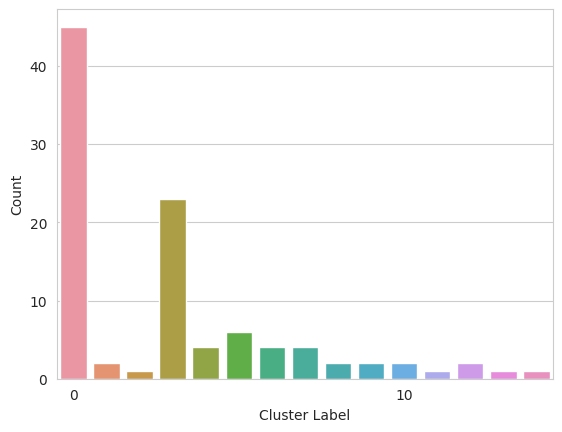

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
ax = sns.countplot(x=labels)
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Count')
ax.set_xticks(range(0, best_n_clusters, 10))
ax.set_xticklabels(range(0, best_n_clusters, 10))

plt.show()

In [65]:
ndf['sil'] = labels

In [66]:
# Get the count of each label
label_counts = ndf['sil'].value_counts()

# Print the label counts
print(label_counts)

0     45
3     23
5      6
4      4
6      4
7      4
8      2
9      2
12     2
10     2
1      2
13     1
11     1
2      1
14     1
Name: sil, dtype: int64


In [68]:
ndf[ndf['sil'] == 0].index

Int64Index([ 0,  5,  8, 11, 16, 21, 22, 23, 24, 26, 27, 28, 29, 32, 35, 36, 38,
            41, 44, 45, 46, 51, 52, 53, 54, 57, 60, 61, 64, 65, 67, 68, 70, 71,
            72, 73, 76, 77, 78, 79, 87, 89, 94, 97, 99],
           dtype='int64')

In [85]:
ndf

,path,inter,over,sil,elbow
0,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1644 [label=""category_nam...",0,0,0
1,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1647 [label=""var: db.secr...",12,4,2
2,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1651 [label=""enabled: Tru...",2,3,3
3,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1654 [label=""msg: This is...",3,8,4
4,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1660 [label=""repo: deb ht...",2,3,3
...,...,...,...,...,...
95,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1961 [label=""name: Displa...",2,3,3
96,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1964 [label=""var: {{ rand...",19,5,5
97,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1968 [label=""image: nginx...",0,0,0
98,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1970 [label=""command: ans...",2,3,3


In [91]:
ndf[ndf['sil'] == 0].index

Int64Index([ 0,  5,  8, 11, 16, 21, 22, 23, 24, 26, 27, 28, 29, 32, 35, 36, 38,
            41, 44, 45, 46, 51, 52, 53, 54, 57, 60, 61, 64, 65, 67, 68, 70, 71,
            72, 73, 76, 77, 78, 79, 87, 89, 94, 97, 99],
           dtype='int64')

In [92]:
ndf.to_pickle('ged_results.pickle')

In [93]:
df = pd.read_pickle('ged_results.pickle')

In [94]:
df

,path,inter,over,sil,elbow
0,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1644 [label=""category_nam...",0,0,0
1,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1647 [label=""var: db.secr...",12,4,2
2,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1651 [label=""enabled: Tru...",2,3,3
3,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1654 [label=""msg: This is...",3,8,4
4,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1660 [label=""repo: deb ht...",2,3,3
...,...,...,...,...,...
95,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1961 [label=""name: Displa...",2,3,3
96,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1964 [label=""var: {{ rand...",19,5,5
97,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1968 [label=""image: nginx...",0,0,0
98,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1970 [label=""command: ans...",2,3,3


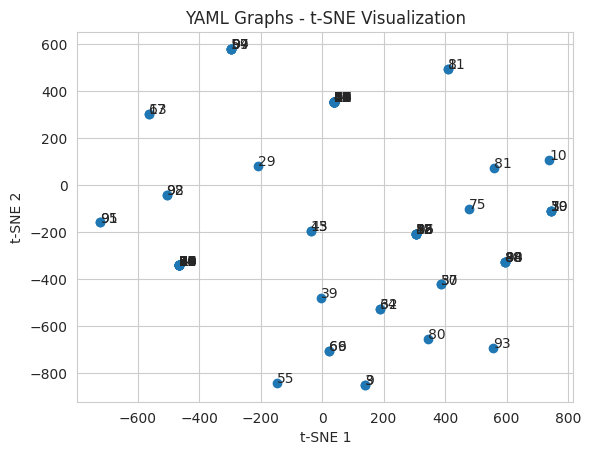

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume you have a distance matrix called 'dist_matrix'

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(dist_matrix)

# Separate the 2D coordinates
x_coords = reduced_data[:, 0]
y_coords = reduced_data[:, 1]

# Create a scatter plot
plt.scatter(x_coords, y_coords)

# Label each point with its index (optional)
for i, txt in enumerate(range(len(x_coords))):
    plt.annotate(txt, (x_coords[i], y_coords[i]))

# Display the plot
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('YAML Graphs - t-SNE Visualization')
plt.show()

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import umap

# Assume you have a distance matrix called 'dist_matrix'

# Use UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='precomputed', random_state=42)
reduced_data = reducer.fit_transform(dist_matrix)

# Separate the 2D coordinates
x_coords = reduced_data[:, 0]
y_coords = reduced_data[:, 1]

# Create a scatter plot
plt.scatter(x_coords, y_coords)

# Label each point with its index (optional)
for i, txt in enumerate(range(len(x_coords))):
    plt.annotate(txt, (x_coords[i], y_coords[i]))

# Display the plot
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('YAML Graphs - UMAP Visualization')
plt.show()

SystemError: initialization of _internal failed without raising an exception